In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Random Forest from the Tutorial

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [4]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


In [5]:
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


## Eavluate RF model performance through crossvalidation

In [6]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# kfold = StratifiedKFold(n_splits = 10).split(X,y)
# scores = []
# for k,(train,test) in enumerate(kfold):
#     model.fit(X.to_numpy()[train,:],y.to_numpy()[train])
#     score = model.score(X.to_numpy()[test],y.to_numpy()[test])
#     scores.append(score)
#     print('Fold: %2d, Class dist: %s, Acc: %.3f'%(k+1,np.bincount(y[train]),score))
# print('CV accuracy %.3f +/- %.3f'%(np.mean(scores),np.std(scores)))
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
scores2 = cross_val_score(estimator = model,
                        X =X,
                        y = y,
                        cv = 10,
                        n_jobs = 1)
print('CV accuracy scores: %s' %scores2)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores2),np.std(scores2)))

CV accuracy scores: [0.75555556 0.78651685 0.76404494 0.84269663 0.82022472 0.75280899
 0.80898876 0.74157303 0.83146067 0.80898876]
CV accuracy: 0.791 +/- 0.034


In [7]:
from sklearn.model_selection import learning_curve
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)

train_sizes, train_scores, test_scores = learning_curve(estimator = model,
                                                       X=X,
                                                       y=y,
                                                       train_sizes = np.linspace(0.1,1,10),
                                                       cv=10,
                                                       n_jobs = 1)

The learning curve below shows signs of **high bias and under-fitting**.

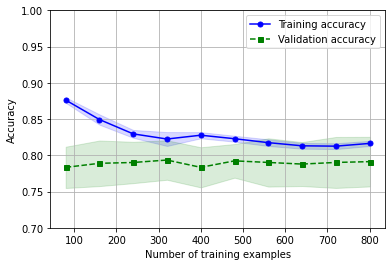

In [8]:
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis = 1)
test_mean = np.mean(test_scores,axis = 1)
test_std = np.std(test_scores,axis = 1)

from matplotlib import pyplot as plt
plt.plot(train_sizes, train_mean,
         color = 'blue',marker = 'o',
        markersize = 5, label = 'Training accuracy')

plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha = 0.15, color = 'blue')

plt.plot(train_sizes, test_mean,
         color = 'green',marker = 's',
         markersize = 5, linestyle = '--', 
         label = 'Validation accuracy')

plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha = 0.15, color = 'green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.ylim([0.7,1])
plt.show()

## Invetsigate effects of RF tree # and max depth on the model accuracy

In [9]:
from sklearn.model_selection import validation_curve
from matplotlib import pyplot as plt

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)

def plot_validation_curve(param_range,param_name,train_scores,test_scores):
    train_mean = np.mean(train_scores,axis=1)
    train_std = np.std(train_scores,axis = 1)
    test_mean = np.mean(test_scores,axis = 1)
    test_std = np.std(test_scores,axis = 1)

    plt.plot(param_range, train_mean,
             color = 'blue',marker = 'o',
            markersize = 5, label = 'Training accuracy')

    plt.fill_between(param_range,
                    train_mean + train_std,
                    train_mean - train_std,
                    alpha = 0.15, color = 'blue')

    plt.plot(param_range, test_mean,
             color = 'green',marker = 's',
             markersize = 5, linestyle = '--', 
             label = 'Validation accuracy')

    plt.fill_between(param_range,
                    test_mean + test_std,
                    test_mean - test_std,
                    alpha = 0.15, color = 'green')

    plt.grid()
    plt.xlabel('Parameter:'+param_name)
    plt.ylabel('Accuracy')
    plt.legend(loc = 'best')
    plt.ylim([0.7,1])
    plt.show()
    


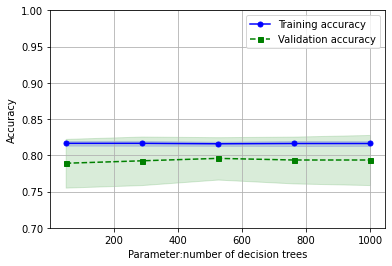

In [10]:
param_range_treenum = np.linspace(50,1000,5).astype(int)
#param_range_treenum = [50,100,150,200]
train_scores,test_scores = validation_curve(estimator = model,
                                           X = X,
                                           y = y,
                                           param_name ='n_estimators',
                                           param_range = param_range_treenum,
                                           cv=10)
plot_validation_curve(param_range_treenum, 'number of decision trees',
                      train_scores,test_scores)

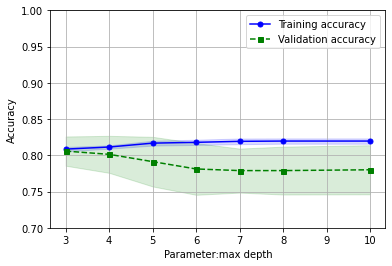

In [11]:
param_range_maxdepth = np.linspace(3,10,7).astype(int)
#param_range_treenum = [50,100,150,200]
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
train_scores,test_scores = validation_curve(estimator = model,
                                           X = X,
                                           y = y,
                                           param_name ='max_depth',
                                           param_range = param_range_maxdepth,
                                           cv=10)
plot_validation_curve(param_range_maxdepth, 'max depth',
                      train_scores,test_scores)

Neither max depth nor the number of decision tree seems to improve the model accuracy much. Especially, as the max depth increases, the gap between training accuracy and validation accuracy widens, indicating the rules learned at the deeper branches do not generalize well.

## Data preprocessing and Feature engineering

This section, I re-preprocess the features. **Added** "Age", "Fare", "Embarked", and "InACabin" as **new features. Improved accuracy from 0.791 to 0.826+/- 0.049.** 

The orgininal model so far uses the original form of 4 features: class, sex, sibsp, parch. We probably want to use other features too. Let's look at all the features first. 



In [12]:
# Age, Cabin and Embarked columns have nan values. I don't want to eliminate those rows
# as NAN may contain information.
# print(train_data.isnull().sum())

In [13]:
# Don't use PassengerId name, ticket columns, as they are unique to individual and
# does not contain useful information.
train_data['InACabin']=train_data['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
Features = ['Pclass','Sex','Age', 'SibSp','Parch','Fare','Cabin','Embarked','InACabin']   
X_add =pd.get_dummies(train_data[Features])
print('Training data size is',X.shape)
X_add.head()

Training data size is (891, 5)


,Pclass,Age,SibSp,Parch,Fare,InACabin,Sex_female,Sex_male,Cabin_A10,Cabin_A14,...,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,38.0,1,0,71.2833,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,26.0,0,0,7.9250,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,35.0,1,0,53.1000,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
#delete the Cabin related columns cause it generated too many new columns after decoding
Features = ['Pclass','Sex','Age', 'SibSp','Parch','Fare','Embarked','InACabin']
X_add =pd.get_dummies(train_data[Features],drop_first=True)
X_add = X_add.fillna(X_add.mean())
print('Training data size is',X.shape)
X_add.head()
# After imputing, there is no missing values in the features data to be used from training the new model.
print(X_add.isnull().sum())

Training data size is (891, 5)
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
InACabin      0
Sex_male      0
Embarked_Q    0
Embarked_S    0
dtype: int64


In [15]:
from sklearn.model_selection import cross_val_score
model_add = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
scores_add = cross_val_score(estimator = model_add,
                        X =X_add,
                        y = y,
                        cv = 10,
                        n_jobs = 1)
print('CV accuracy scores: %s' %scores_add)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_add),np.std(scores_add)))

model_add.fit(X_add,y)
importances = model_add.feature_importances_
indices = np.argsort(importances)[::-1]

feat_labels = X_add.columns
for f in range(X_add.shape[1]):
    print("%2d) %-*s %f" % (f+1,30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

CV accuracy scores: [0.8        0.82022472 0.75280899 0.87640449 0.92134831 0.80898876
 0.79775281 0.7752809  0.87640449 0.83146067]
CV accuracy: 0.826 +/- 0.049
 1) Sex_male                       0.461807
 2) Fare                           0.150010
 3) Pclass                         0.118828
 4) Age                            0.092334
 5) InACabin                       0.079159
 6) SibSp                          0.045460
 7) Parch                          0.026210
 8) Embarked_S                     0.017281
 9) Embarked_Q                     0.008912


In [16]:
print(indices)
print('Features are %s, length is %d'%(feat_labels,len(feat_labels)))

[6 4 0 1 5 2 3 8 7]
Features are Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'InACabin', 'Sex_male',
       'Embarked_Q', 'Embarked_S'],
      dtype='object'), length is 9


In [17]:
X_add.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'InACabin', 'Sex_male',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')